# Credi Fiel

- Ana Paola Almeida
- Cynthia Cristal
- Daniela Marquez
- Viviana Alanis

## Importar librerías

In [65]:
import pandas as pd
import pickle

from itertools import product
from sklearn.metrics import f1_score
from datetime import datetime
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

## Cargar datos

In [66]:
df_2022 = pd.read_csv("ExtraccionDomiVersionFinal/ListaCobroDetalle2022.csv")
df_2023 = pd.read_csv("ExtraccionDomiVersionFinal/ListaCobroDetalle2023.csv")
df_2024 = pd.read_csv("ExtraccionDomiVersionFinal/ListaCobroDetalle2024.csv")
df_2025 = pd.read_csv("ExtraccionDomiVersionFinal/ListaCobroDetalle2025.csv")

C:\Users\HP\AppData\Local\Temp\ipykernel_16136\256103267.py:2: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  df_2023 = pd.read_csv("ExtraccionDomiVersionFinal/ListaCobroDetalle2023.csv")


## Diccionario

In [67]:
# El diccionario de reemplazos
reemplazos_id_respuesta_banco = {
    "00": ["20", "DOM1", "INC0"],
    "01": ["51", "DD00021", "DOM7"],
    "02": ["52", "DD00025", "DOM10", "INC16"],
    "03": ["53", "DD00026", "DOM5", "INC9"],
    "04": ["DD00001", "DD00019", "DD00022", "DD00031", "DOM2", "DOM6", "INC23", "INC6"],
    "05": [],
    "06": [],
    "07": ["DOM14"],
    "08": [],
    "09": ["DD00028", "DOM9"],
    "10": ["DD00033", "DOM4"],
    "11": ["24"],
    "12": ["DD00020", "DOM12", "DOM13", "DOM8"],
    "13": [],
    "14": ["99"],
    "15": ["81"],
    "16": ["82", "83"],
    "17": [],
    "18": ["22"],
    "19": [],
    "21": [],
    "23": [],
    "25": ["DD00030"],
    "26": ["INC7"],
    "88": [],
    "90": ["91", "92", "93", "94", "95", "96", "97", "98", "99", "100"],
    "91": ["DD00023", "DD00027", "DD00029", "DD00034", "DD00035", "DD00037", "DD00038", "DD00039", "DD00040", "DOM11", "DOM3", "DD00041", "DD00042"],
    "92": ["DD00024"],
    "94": ["DD00036", "DD00043"],
    "95": ["INC1"],
    "96": ["INC10"],
    "97": ["INC11"],
    "98": ["INC15"],
    "99": ["INC17"],
    "100": ["INC18"],
    "101": ["INC19"],
    "102": ["INC2"],
    "103": ["INC21"],
    "104": ["INC22"],
    "105": ["INC4"],
    "106": ["INC3"],
    "107": ["INC5"],
    "108": ["INC8"],
}

# Invertimos el diccionario para mapear de valor a código
mapa_invertido = {valor: clave for clave, lista in reemplazos_id_respuesta_banco.items() for valor in lista}

# Función para reemplazar
def reemplazar_id_respuesta(df):
    df["idRespuestaBanco"] = df["idRespuestaBanco"].map(mapa_invertido).fillna(df["idRespuestaBanco"])
    return df

### Aplicar función

#### 2022

In [68]:
df_2022_1 = reemplazar_id_respuesta(df_2022)

In [69]:
df_2022_1["idRespuestaBanco"].value_counts()

idRespuestaBanco
04    290435
00     11763
08      2230
09      1560
26      1216
01      1047
03       665
02       642
12       461
30       214
10        47
13        36
91        24
19        23
16         1
88         1
Name: count, dtype: int64

#### 2023

In [70]:
# Reemplazar valores numéricos decimales por enteros en la columna idRespuestaBanco de todos los dataframes relevantes
for df_temp in [df_2022, df_2023, df_2024, df_2025]:
    df_temp["idRespuestaBanco"] = df_temp["idRespuestaBanco"].apply(
        lambda x: f"{int(x):02d}" if (isinstance(x, float) and x.is_integer() and int(x) < 10) or (isinstance(x, int) and x < 10) else (str(int(x)) if (isinstance(x, float) and x.is_integer()) else x)
    )

In [71]:
df_2023_1 = reemplazar_id_respuesta(df_2023)

In [72]:
df_2023_1["idRespuestaBanco"].value_counts()

idRespuestaBanco
04    1567133
00      53500
13      13122
26       6774
08       6014
01       3573
12       2950
02       2941
03       2763
30       1361
09        264
19        205
36        183
40        164
91         69
10         53
42         40
88         23
18          4
Name: count, dtype: int64

#### 2024

In [73]:
df_2024_1 = reemplazar_id_respuesta(df_2024)
df_2024_1["idRespuestaBanco"].value_counts()

idRespuestaBanco
04    5645833
00     159088
13      15961
26       8085
02       6070
03       3301
08       2410
01       2224
36       1154
30        395
40        131
88         41
10         15
84          7
42          2
37          1
06          1
18          1
Name: count, dtype: int64

#### 2025

In [74]:
df_2025_1 = reemplazar_id_respuesta(df_2025)
df_2025_1["idRespuestaBanco"].value_counts()

idRespuestaBanco
04    2010908
00      69552
13       5894
08       2693
26       1074
03        699
02        569
01        143
30         82
40         22
36         11
88          6
10          4
06          1
Name: count, dtype: int64

## Acotar bases por año

In [75]:
def muestreo_balanceado(df, n=10000):

    # Muestreo de clase '00'
    muestra_00 = df[df['idRespuestaBanco'] == '00'].sample(n=min(n, df['idRespuestaBanco'].eq('00').sum()), random_state=42)
    
    # Muestreo de otras clases
    bancos_validos = [2, 12, 14, 72] # unicamente bancos con comision por registro enviado 
    df_filtrado = df[df['idBanco'].isin(bancos_validos)]
    muestra_00 = df_filtrado[df_filtrado['idRespuestaBanco'] == '00'].sample(n=min(n, df_filtrado['idRespuestaBanco'].eq('00').sum()), random_state=42)
    muestra_otros = df[df['idRespuestaBanco'] != '00'].sample(n=min(n, df['idRespuestaBanco'].ne('00').sum()), random_state=42)
    
    # Concatenar ambos
    return pd.concat([muestra_00, muestra_otros], ignore_index=True)

df_2022_1 = muestreo_balanceado(df_2022_1, 10000)
df_2023_1 = muestreo_balanceado(df_2023_1, 10000)
df_2024_1 = muestreo_balanceado(df_2024_1, 10000)
df_2025_1 = muestreo_balanceado(df_2025_1, 10000)

## Unir dataframes

In [76]:
# Juntar muestras a un df
df = pd.concat([df_2022_1, df_2023_1, df_2024_1, df_2025_1], ignore_index=True)
df.head()

,idListaCobro,idCredito,consecutivoCobro,idBanco,montoExigible,montoCobrar,montoCobrado,fechaCobroBanco,idRespuestaBanco
0,105654,526955,29776700,14,312.89,312.89,312.89,30/11/2022,00
1,103235,550653,29455488,2,185.37,185.37,185.37,28/10/2022,00
2,105584,636937,29756190,14,222.53,222.53,222.53,28/11/2022,00
3,105585,368415,29756597,2,433.37,433.37,433.37,25/11/2022,00
4,102916,402225,29398987,2,683.26,683.26,683.26,26/10/2022,00


In [77]:
df.shape

(80000, 9)

In [78]:
df.columns

Index(['idListaCobro', 'idCredito', 'consecutivoCobro', 'idBanco',
       'montoExigible', 'montoCobrar', 'montoCobrado', 'fechaCobroBanco',
       'idRespuestaBanco'],
      dtype='object')

## Eliminar columnas

In [79]:
df = df.drop(columns=["consecutivoCobro"])

In [80]:
df.columns

Index(['idListaCobro', 'idCredito', 'idBanco', 'montoExigible', 'montoCobrar',
       'montoCobrado', 'fechaCobroBanco', 'idRespuestaBanco'],
      dtype='object')

## Crear columnas nunIntentosTot y numIntentosExitosos

In [81]:
# Crear la columna "numIntentosTot" que cuenta el número total de intentos por idCredito
df["numIntentosTot"] = df.groupby("idCredito")["idCredito"].transform("count")

In [84]:
# Crear la columna "numIntentosTot_2024" que cuenta el número de intentos por idCredito solo para el año 2024
df['fechaCobroBanco'] = pd.to_datetime(df['fechaCobroBanco'], dayfirst=True, errors='coerce')

# Crear la columna "numIntentosTot_2024" que cuenta el número de intentos por idCredito solo para el año 2024
df['numIntentosTot_2024'] = df.groupby('idCredito')['fechaCobroBanco'].transform(
    lambda x: ((x.dt.year == 2024).sum() if x.notnull().any() else 0)
)

In [85]:
# Crear la columna "numIntentosExitosos" que cuenta el número de intentos exitosos (idRespuestaBanco == '00') por idCredito
df["numIntentosExitosos"] = df.groupby("idCredito")["idRespuestaBanco"].transform(lambda x: (x == "00").sum())

In [86]:
df.head()

,idListaCobro,idCredito,idBanco,montoExigible,montoCobrar,montoCobrado,fechaCobroBanco,idRespuestaBanco,numIntentosTot,numIntentosTot_2024,numIntentosExitosos
0,105654,526955,14,312.89,312.89,312.89,2022-11-30,00,2,0,2
1,103235,550653,2,185.37,185.37,185.37,2022-10-28,00,2,0,1
2,105584,636937,14,222.53,222.53,222.53,2022-11-28,00,4,0,3
3,105585,368415,2,433.37,433.37,433.37,2022-11-25,00,5,0,2
4,102916,402225,2,683.26,683.26,683.26,2022-10-26,00,6,0,6


## Tipo de Servicio

In [87]:
df_cap_pagare = pd.read_csv("ExtraccionDomiVersionFinal/Capital_Pagare_FechaAperturaCredito(in).csv")
df_cap_pagare.head()

,idcredito,pagare,capital,fechaAperturaCredito
0,10456,120379.68,50000.0,26/05/2008
1,10439,122306.40,50800.0,3/6/2008
2,10297,132333.12,46000.0,9/6/2008
3,10327,77535.84,40000.0,13/06/2008
4,10073,96304.32,40000.0,30/06/2008


In [88]:
df_catEmisora = pd.read_csv("ExtraccionDomiVersionFinal/CatEmisora(in).csv")
df_catEmisora.head()

,idEmisora,Nombre,IdBanco,Emisora,TipoEnvio
0,1,BANAMEX CLABE TRADICIONAL,2,NoAplica,TRADICIONAL
1,2,BANAMEX CUENTA,2,NoAplica,CUENTA
2,3,BANAMEX TARJETA,2,NoAplica,TARJETA
3,4,BANAMEX INTERBANCARIO,2,NoAplica,INTERBANCARIO
4,5,BANAMEX TRADICIONAL REINTENTO,2,NoAplica,TRADICIONAL


In [89]:
df_listaCobroEmisora = pd.read_csv("ExtraccionDomiVersionFinal/ListaCobroEmisora.csv")
df_listaCobroEmisora.head()

,idListaCobro,idEmisora
0,79678,20
1,80111,20
2,80584,20
3,80941,19
4,81214,20


In [90]:
df = df.merge(df_cap_pagare, left_on="idCredito", right_on="idcredito", how="left")

In [91]:
df = df.merge(df_listaCobroEmisora, left_on="idListaCobro", right_on="idListaCobro", how="left")

In [92]:
df = df.merge(df_catEmisora, left_on="idEmisora", right_on="idEmisora", how="left")

In [93]:
def servicio_corregido(nombre):
    nombre = str(nombre).lower()
    if 'interbancaria' in nombre or 'interbancario' in nombre:
        return 'Interbancario'
    elif 'tradicional' in nombre:
        return 'Tradicional'
    elif 'parcial' in nombre:
        return 'Parcial'
    elif 'matutino' in nombre:
        return 'matutino'
    elif 'en linea' in nombre:
        return 'En linea'
    else:
        return 'No aplica'

In [94]:
df['TipoEnvio'] = df['TipoEnvio'].copy()
df['Servicio'] = df['Nombre'].apply(servicio_corregido)
df = df.drop(columns=['TipoEnvio'])

## Antiguedad de credito

In [95]:
# Crear variable de fecha actual
fecha_actual = pd.Timestamp(datetime.now().date())

# Convertir columnas de fecha a tipo datetime
df['fechaCobroBanco'] = pd.to_datetime(df['fechaCobroBanco'], dayfirst=True, errors='coerce')
df['fechaAperturaCredito'] = pd.to_datetime(df['fechaAperturaCredito'], dayfirst=True, errors='coerce')

# Calcular antigüedad como la diferencia en días entre la fecha actual y la fecha de apertura del crédito
df['antiguedad'] = (fecha_actual - df['fechaAperturaCredito']).dt.days

In [96]:
df.isnull().sum()

idListaCobro                0
idCredito                   0
idBanco                     0
montoExigible               0
montoCobrar                 0
montoCobrado                0
fechaCobroBanco         39685
idRespuestaBanco         1719
numIntentosTot              0
numIntentosTot_2024         0
numIntentosExitosos         0
idcredito                   6
pagare                      6
capital                     6
fechaAperturaCredito        6
idEmisora                   0
Nombre                    155
IdBanco                   155
Emisora                   155
Servicio                    0
antiguedad                  6
dtype: int64

## Tratar valores nulos

In [97]:
df = df[df[['idcredito', 'idRespuestaBanco']].notnull().all(axis=1)]

In [98]:
df.isnull().sum()

idListaCobro                0
idCredito                   0
idBanco                     0
montoExigible               0
montoCobrar                 0
montoCobrado                0
fechaCobroBanco         38275
idRespuestaBanco            0
numIntentosTot              0
numIntentosTot_2024         0
numIntentosExitosos         0
idcredito                   0
pagare                      0
capital                     0
fechaAperturaCredito        0
idEmisora                   0
Nombre                      0
IdBanco                     0
Emisora                     0
Servicio                    0
antiguedad                  0
dtype: int64

In [99]:
df.drop(columns=["idcredito"])

,idListaCobro,idCredito,idBanco,montoExigible,montoCobrar,montoCobrado,fechaCobroBanco,idRespuestaBanco,numIntentosTot,numIntentosTot_2024,numIntentosExitosos,pagare,capital,fechaAperturaCredito,idEmisora,Nombre,IdBanco,Emisora,Servicio,antiguedad
0,105654,526955,14,312.89,312.89,312.89,2022-11-30,00,2,0,2,50216.40,20400.00,2019-12-10,21,BBVA CLABE EN LINEA,12.0,7455,En linea,1993.0
1,103235,550653,2,185.37,185.37,185.37,2022-10-28,00,2,0,1,8897.76,5000.00,2020-07-02,36,Banamex Reintentos ...,2.0,noAplica,No aplica,1788.0
2,105584,636937,14,222.53,222.53,222.53,2022-11-28,00,4,0,3,21362.88,8000.00,2022-09-26,21,BBVA CLABE EN LINEA,12.0,7455,En linea,972.0
3,105585,368415,2,433.37,433.37,433.37,2022-11-25,00,5,0,2,41603.52,17909.33,2017-01-27,23,BBVA CLABE PARCIAL,12.0,6111,Parcial,3040.0
4,102916,402225,2,683.26,683.26,683.26,2022-10-26,00,6,0,6,81991.20,29998.47,2017-09-26,23,BBVA CLABE PARCIAL,12.0,6111,Parcial,2798.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79995,158151,738629,12,859.09,859.09,0.00,NaT,04,3,0,1,44672.68,15900.00,2024-12-18,6,BBVA TRADICIONAL REINTENTO,12.0,REINTENTO,Tradicional,158.0
79996,161095,714970,2,128.77,128.77,0.00,NaT,04,6,0,0,30905.28,11000.00,2024-07-12,1,BANAMEX CLABE TRADICIONAL,2.0,NoAplica,Tradicional,317.0
79997,156800,686598,72,549.63,549.63,0.00,NaT,04,2,1,1,87940.32,31300.00,2023-11-28,12,BANORTE CLABE TRADICIONAL,72.0,496,Tradicional,544.0
79998,159013,729437,2,1755.99,1755.99,0.00,NaT,04,8,1,3,84287.52,30000.00,2024-10-09,1,BANAMEX CLABE TRADICIONAL,2.0,NoAplica,Tradicional,228.0


In [100]:
df.shape

(78275, 21)

## Pago Relativo en el ciclo

In [101]:
df['porcentaje_pagado'] = df['montoCobrado'] / df['pagare']
df['esExitoso'] = (df['montoCobrado'] > 0).astype(int)  # target binario

## Random Forest Generico

In [102]:
features = [
    'capital', 'pagare', 'antiguedad',
    'idBanco', 'Servicio', 'idEmisora'
]
target = 'esExitoso'

In [103]:
# Dividir datos
X = df[features]
y = df[target]

# Columnas categóricas
cat_cols = ['idBanco', 'Servicio', 'idEmisora']
num_cols = ['capital', 'pagare', 'antiguedad']

# Pipeline de preprocesamiento
preprocessor = ColumnTransformer([
    ('num', 'passthrough', num_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
])

# Modelo
model = make_pipeline(preprocessor, RandomForestClassifier(n_estimators=100, random_state=42))

# Entrenamiento
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model.fit(X_train, y_train)

print("Accuracy en validación:", model.score(X_test, y_test))

Accuracy en validación: 0.800127754710955


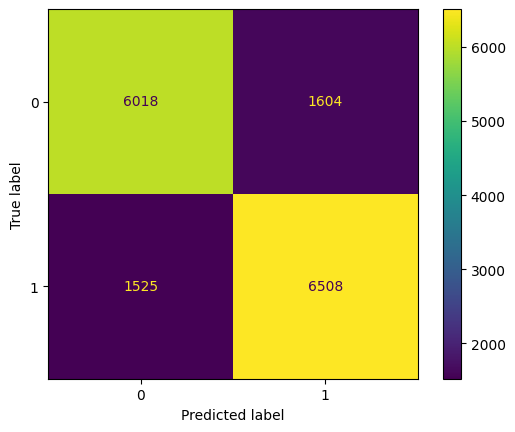

In [104]:
# Predecir en el conjunto de prueba
y_pred = model.predict(X_test)

# Calcular matriz de confusión
cm = confusion_matrix(y_test, y_pred)

# Mostrar matriz de confusión
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

In [105]:
f1 = f1_score(y_test, y_pred)
print("F1 Score:", f1)

F1 Score: 0.8061938680706101


In [106]:
df['IdBanco'].value_counts()

IdBanco
12.0    38271
2.0     27279
14.0     9991
72.0     2734
Name: count, dtype: int64

## Guardar modelo

In [107]:
with open("model.pkl", "wb") as f:
    pickle.dump(model, f)

## Predicción de mejor combinacion

In [108]:
# Listas posibles (basadas en los valores históricos del dataset)
bancos = df['idBanco'].unique()
servicios = df['Servicio'].unique()
emisoras = df['idEmisora'].unique()

# Generar todas las combinaciones posibles
combinaciones = list(product(bancos, servicios, emisoras))
print(bancos)

[ 14   2  72  12  21  36  44 127  62 131  30 166  58 137 132]


In [109]:
# Características del crédito
base_credito = {
    'capital': 12000,
    'pagare': 15000,
    'antiguedad': 90
}

In [110]:
# Expandir ese crédito con cada combinación posible
data = []
for banco, servicio, emisoras in combinaciones:
    row = base_credito.copy()
    row.update({'idBanco': banco, 'Servicio': servicio, 'idEmisora': emisoras})
    data.append(row)

df_combos = pd.DataFrame(data)

In [111]:
# Predecir con el modelo
probas = model.predict_proba(df_combos)
df_combos['proba_exito'] = probas[:, 1]

In [112]:
# Ordenar y mostrar la mejor combinación
mejor = df_combos.sort_values(by='proba_exito', ascending=False).head(1)
print("Mejor combinación recomendada:")
print(mejor[['idBanco', 'Servicio', 'idEmisora','proba_exito']])

Mejor combinación recomendada:
     idBanco Servicio  idEmisora  proba_exito
542       12  Parcial         23         0.96


## Prediccion de las mejores 5 combinaciones

In [113]:
# Mostrar las 5 combinaciones con mayor probabilidad de éxito
top5 = df_combos.sort_values(by='proba_exito', ascending=False).head(5)
print("Top 5 combinaciones recomendadas:")
print(top5[['idBanco', 'Servicio', 'idEmisora', 'proba_exito']])

Top 5 combinaciones recomendadas:
     idBanco     Servicio  idEmisora  proba_exito
542       12      Parcial         23        0.960
561       12      Parcial         17        0.960
349       72     En linea         15        0.940
554       12      Parcial         24        0.930
124       14  Tradicional          9        0.926


## Modelo regresor para predecir numero de intentos

In [114]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd

# Variable objetivo: numIntentosTot
target_reg = 'numIntentosTot_2024'

# Selección de variables predictoras (puedes ajustar según importancia)
features_reg = [
    'capital', 'pagare', 'antiguedad',
    'idBanco', 'Servicio', 'idEmisora'
]

# Preparar datos
X_reg = df[features_reg]
y_reg = df[target_reg]

# Dividir datos
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X_reg, y_reg, test_size=0.2, random_state=42)

# Pipeline de preprocesamiento + modelo
model_reg = make_pipeline(
    ColumnTransformer([
        ('num', 'passthrough', ['capital', 'pagare', 'antiguedad']),
        ('cat', OneHotEncoder(handle_unknown='ignore'), ['idBanco', 'Servicio', 'idEmisora'])
    ]),
    RandomForestRegressor(n_estimators=100, random_state=42)
)

# Entrenar modelo
model_reg.fit(X_train_reg, y_train_reg)

# Predicción y métricas
y_pred_reg = model_reg.predict(X_test_reg)
print("MSE:", mean_squared_error(y_test_reg, y_pred_reg))
print("R2 Score:", r2_score(y_test_reg, y_pred_reg))

MSE: 0.1659473521725359
R2 Score: 0.8908882406445244


## Guardar Modelo

In [115]:
with open("model_reg.pkl", "wb") as f:
    pickle.dump(model, f)

In [116]:
top5['numIntentosTot_pred'] = model_reg.predict(top5[features_reg])
print(top5[['idBanco', 'Servicio', 'idEmisora', 'proba_exito', 'numIntentosTot_pred']])

     idBanco     Servicio  idEmisora  proba_exito  numIntentosTot_pred
542       12      Parcial         23        0.960                  0.0
561       12      Parcial         17        0.960                  0.0
349       72     En linea         15        0.940                  0.0
554       12      Parcial         24        0.930                  0.0
124       14  Tradicional          9        0.926                  0.0
